# Sentiment Analysis on Stock Headlines

In this tutorial we use various methods to calculate the sentiment (positive or negative) associated with headlines related to various stocks.  We compare this sentiment to the *event return* of the stock, which is the return of the stock around the date of the headline.  Ultimately we are interested in seeing if there is a positive correlation with the sentiments calculated and the event return.  If there is a significant positive correlation, we could build a trading strategy around the sentiment analysis.

## Importing Packages

Let's begin my importing some initial packages.

In [ ]:
import pandas as pd
import numpy as np

## Reading-In Data

Next, let's read in and examine our data.  It consists of 2,768 headlines related to various stocks.  Associated with each headline is the *event return* of the relevant stock. Event return is defined as:

\begin{align*}
R_{t–1} + R_{t} + R_{t+1}
\end{align*}

where $R_{t–1}$, $R_{t+1}$ are the returns the days before and after the news data, and $R_t$ is the return on
the day of the news.  We do this because at times the news is reported late (i.e., after market participants are already aware of the announcement) or after market close. Having a slightly wider window ensures that we capture the essence of the event.

Ultimately, we are interested to see if we can calculate sentiments for the headlines that are positively correlated with the `eventRet`.

In [ ]:
df_news_return = pd.read_csv('Step3_NewsAndReturnData.csv', delimiter='|')
df_news_return

,ticker,headline,date,eventRet,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63
4,MSFT,NaN,2011-05-10,-0.019823,20.63
...,...,...,...,...,...
2763,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,295.39
2764,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,1343.96
2765,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005634,143.92
2766,TSLA,Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...,2018-12-26,-0.002856,326.09


## Using **textblob**

We'll begin by calculating sentiments using the built-in sentiment analyzer in the **textblob** package.

The **texblob** sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews (source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective).

In [ ]:
from textblob import TextBlob

Let's apply the `TextBlob()` function to an example headline.

In [ ]:
example_headline = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

TextBlob(example_headline).sentiment.polarity

0.5

Let's compute the sentiment for all the headlines in the data.

In [ ]:
df_news_return['sentiment_textblob'] = [TextBlob(str(s)).sentiment.polarity for s in df_news_return['headline']]
df_news_return

,ticker,headline,date,eventRet,Close,sentiment_textblob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556
4,MSFT,NaN,2011-05-10,-0.019823,20.63,0.000000
...,...,...,...,...,...,...
2763,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,295.39,-0.156250
2764,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,1343.96,0.200000
2765,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005634,143.92,-0.012500
2766,TSLA,Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...,2018-12-26,-0.002856,326.09,0.000000


Let's see how the `TextBlob()` sentiments correlate with the `eventRet`.  As we can see the correlation is +4.2%, which is directionally correct but quite low.

In [ ]:
correlation = df_news_return['eventRet'].corr(df_news_return['sentiment_textblob'])
print(correlation)

0.04257233738490116


## Supervised Techniques - **sklearn**

Next, we develop our own models for sentiment analysis, based on some labeled financial headline data from Kaggle.  Let's read-in the data that we will use to train our models.

In [ ]:
df_news_labeled = pd.read_csv('LabelledNewsData.csv', encoding='unicode_escape')
df_news_labeled

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0
...,...,...,...,...
9465,4/11/2019 1:24,$WMT - Walmart shifts to remodeling vs. new st...,WMT,1
9466,4/10/2019 6:05,Walmart INC $WMT Holder Texas Permanent School...,WMT,0
9467,4/9/2019 4:38,$WMT $GILD:3 Dividend Stocks Perfect for Retir...,WMT,1
9468,4/9/2019 4:30,Walmart expanding use of #robots to scan shelv...,WMT,1


As we can see, the Kaggle data is fairly balanced with about 58% positive sentiments, consists of 30 tickers, each of which are fairly uniformly represented.

In [ ]:
df_news_labeled['sentiment'].mean()

0.5788806758183738

In [ ]:
print("Number of Tickers: ", len(df_news_labeled['ticker'].unique()))

Number of Tickers:  30


In [ ]:
df_news_labeled['ticker'].value_counts()

ticker
HD      350
UTX     350
JPM     349
INTC    348
MMM     347
IBM     346
MRK     345
WMT     344
CVX     343
UNH     339
PFE     337
CSCO    337
VZ      335
PG      334
CAT     332
V       326
TRV     326
MCD     326
MSFT    324
JNJ     322
AXP     320
BA      318
KO      309
DIS     300
WBA     283
NKE     273
AAPL    271
XOM     259
DOW     190
GS      187
Name: count, dtype: int64

In order to run a supervised learning model, we first need to convert the news headlines into a vector feature representation. For this exercise, we will use the word embedding built into the **spaCy** package.  The word embedding model includes 20,000 unique vectors with 300 dimensions. We apply this model to all  the `headlines` in `df_news_labeled`.

Let's first import the **spaCy** package.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

Next, let's see the word embedding for a single word.

In [ ]:
doc = nlp('fell')
type(doc)

spacy.tokens.doc.Doc

In [ ]:
for token in doc:
    print(token.vector)

[  1.1734    -7.2025     0.27734   -5.4665     2.8386    -2.496
   1.1509     9.5497     4.8894    -2.7378    -1.0221     3.1214
  -1.5272     1.2968     0.78371    3.3423    -4.3773    -6.473
   3.9741     2.4101    -0.91515   -4.1784    -1.9259    -5.7423
  -5.1056    -2.5617     3.7718    -4.4208     9.0647     1.4237
   1.2726     0.5712    -1.4489    -2.7199    -5.1065    -1.6203
  -3.0038     1.116     -0.44994    1.5537     2.9035     2.288
   6.2687    -0.10803    0.36491   -2.2931    -3.9193     2.7295
   1.989      1.8773    -0.70424    2.7992    -4.6728     1.1616
  -0.06419    2.7225     4.4624    -4.8996     2.086      4.1729
  -1.074     -3.9116     1.0264     2.848     -0.97624    0.48979
   2.5099     4.0977     2.7164    -2.7599     2.1031     0.16324
  -1.5091     3.9319     1.5492     3.1728     0.44398    5.1455
  -1.7672    -0.12588   -3.2237    -0.96587    2.5144     2.616
   1.7276     0.3823     2.1233    -1.3669    -1.9021     1.01
   0.13405    3.0058    -3.88

In order to associate a single vector with headline, we will calculate the mean vector of all the words in the headline.  In the following code we are calculating the word-embedding for each of the words in the headline and taking the average of all of them.  This results in a single 300-dimensional vector for each headline.

In [ ]:
%%time
all_vectors = np.array([np.array([token.vector for token in nlp(s)]).mean(axis=0) for s in df_news_labeled['headline']])

CPU times: user 50 s, sys: 23.9 ms, total: 50.1 s
Wall time: 50.1 s


In [ ]:
all_vectors.shape

(9470, 300)

Now we have our headlines *featurized* and we can use them as training data for a variety of classification models.  

We next import the functions that we will need from **sklearn**.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

Let's organize our features and our labels as well as create a training and test sets.

In [ ]:
X = all_vectors
Y = df_news_labeled['sentiment']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

Next, let's create a `list` of models that we are going to fit to our data.

In [ ]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

The following `for`-loop iterates through all the models, fits each one, and stores the results for further analysis.

In [ ]:
#results = []
names = []
test_results = []
train_results = []
for name, model in models:
    # collecting names of models
    names.append(name)
    
    # fitting on training data
    model.fit(X_train, Y_train)
    train_result = accuracy_score(model.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # checking accuracy on testing data
    test_result = accuracy_score(model.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = f'{name}: {train_result:.4f} {test_result:.4f}'
    print(msg)

LR: 0.8979 0.8793
KNN: 0.8457 0.7628
CART: 0.9998 0.6948
SVM: 0.8603 0.8434
NN: 0.9988 0.9109
RF: 0.9998 0.7941


Let's compare the various models by plotting their training and testing accuracy.  As you can see the neural network model seems to perform the best.

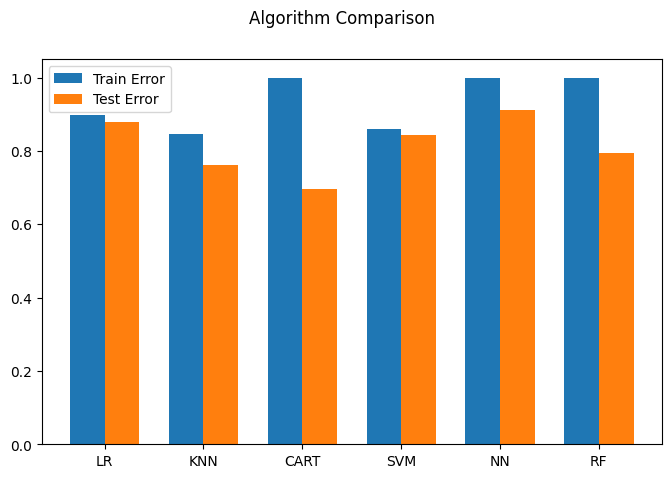

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(8,5)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

## LTSM - **keras**

We will also include LSTM, which is an RNN-based model, in the list of models considered. RNNs process sequences of data (in our case words in a headline) and thus are well suited for NLP. In particular, LSTMs maintain a memory of past information, which enables the model to predict the current output conditioned on long distance features and looks at the words in the context of the entire sentence, rather than simply looking at the individual words.

Let's begin by importing some of the **keras** objects that we will need.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
#from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers import Dense, LSTM
from keras.layers import Embedding

2023-11-24 19:08:29.794136: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 19:08:29.824234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 19:08:29.824264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 19:08:29.824295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 19:08:29.830129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 19:08:29.830633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

As with any NLP modeling excercise, we will need to process our `headlines` to be usable in our LSTM model. For us to be able to feed the data into our LSTM model, all input documents must have the same length. We use the **keras** `Tokenizer` function to tokenize the strings and then use `.texts_to_sequences()` to make sequences of words. We will limit the maximum review length to `maxlen=50` by truncating longer reviews and pad shorter reviews with a null value (0). We can accomplish this using the `pad_sequences` function, also in **keras**.

In [ ]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_news_labeled['headline'])
sequences = tokenizer.texts_to_sequences(df_news_labeled['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Let's separate out our labels and create a holdout set.

In [ ]:
Y_LSTM = df_news_labeled['sentiment']
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = \
    train_test_split(X_LSTM, Y_LSTM, test_size=0.3, random_state=0)

In the following code snippet, we use the **keras** library to build an artificial neural network classifier based on an LSTM model. 

Notice that the network starts with an `Embedding` layer.  Unlike our previous models where we were using the pre-trained embedding in the **spaCy** package, in this model we are learning our own word embedding.  The `Embedding` layer lets the system expand each token to a larger vector, allowing the network to represent a word in a meaningful way. The layer takes 20,000 as the first argument (i.e., the size of our vocabulary) and 300 as the second input parameter (i.e., the dimension of the embedding). 

Finally, given that this is a classification problem and the output needs to be labeled as zero or one, the `KerasClassifier()` function is used as a wrapper over the LSTM model to produce a binary (zero or one) output.

In [ ]:
from scikeras.wrappers import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(model=create_model, epochs=3, verbose=True, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
125/125 [==============================] - 15s 102ms/step - loss: 0.4835 - accuracy: 0.7978 - val_loss: 0.1638 - val_accuracy: 0.9434
Epoch 2/3
125/125 [==============================] - 13s 101ms/step - loss: 0.0674 - accuracy: 0.9811 - val_loss: 0.0982 - val_accuracy: 0.9679
Epoch 3/3
125/125 [==============================] - 13s 102ms/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 0.1040 - val_accuracy: 0.9661


KerasClassifier(
	model=<function create_model>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.4
	shuffle=True
	run_eagerly=False
	epochs=3
	class_weight=None
)

Let's calculate the a in-sample and out-of-sample accuracy and store them for plotting below.

In [ ]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)
train_results.append(train_result_LSTM)
test_results.append(test_result_LSTM)
names.append('LSTM')

89/89 [==============================] - 1s 9ms/step


In [ ]:
print('LTSM Training Accuracy: ', train_result_LSTM)
print('LTSM Testing Accuracy: ', test_result_LSTM)

LTSM Training Accuracy:  0.9855181777040277
LTSM Testing Accuracy:  0.966913058782119


Let's add in our LSTM model results to our previous results and plot again.

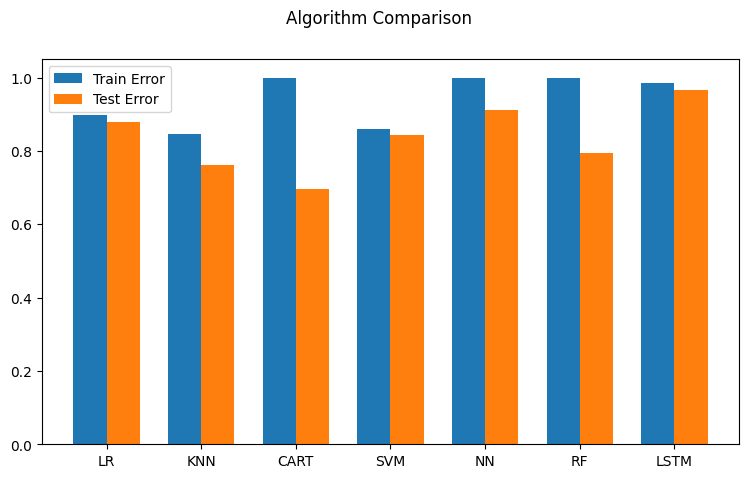

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(9, 5)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

The LSTM model has the best performance on the test set as compared to all other models. The performance of the ANN is comparable to the LSTM-based model. The performances of random forest (RF), SVM, and logistic regression (LR) are reasonable as well. CART and KNN do not perform as well as other models. CART shows significant overfitting.

## LTSM Model Correlations with `eventRet`

Of all the custom sentiment models that we fit to our Kaggle data, the LTSM seems to perform the best.  So in this final section, let's use our LSTM model to predict sentiments on our `headlines` in `df_news_return` and check the correlation with the `eventRet`.  

As a first step, we need to get the `headlines` in a format that can be fed into the LSTM model.

In [ ]:
sequences_LSTM = tokenizer.texts_to_sequences(df_news_return['headline'].astype(str))
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)
X_LSTM

array([[   0,    0,    0, ...,   46, 3856,  307],
       [   1,   36,   16, ...,  273,    1,  801],
       [   0,    0,    0, ...,  159,  224, 3293],
       ...,
       [   0,    0,    0, ..., 7131, 2035, 1422],
       [   0,    0,    0, ..., 1881,  232,  154],
       [   0,    0,    0, ..., 9673, 5060, 2057]], dtype=int32)

In [ ]:
X_LSTM.shape

(2768, 50)

Next, we use the `.predict()` method of our fitted model make our predictions and store them in `df_news_return`.

In [ ]:
Y_LSTM = model_LSTM.predict(X_LSTM)
df_news_return['sentiment_LSTM'] = Y_LSTM 
df_news_return.head()

87/87 [==============================] - 1s 9ms/step


,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,0.262500,1
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,-0.043750,1
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,0.166667,1
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,-0.030556,1
4,MSFT,NaN,2011-05-10,-0.019823,20.63,0.000000,1


Let's now check the correlation between `sentiment_LSTM` and `eventRet`.  As we can see, there is improvement over the `Textblob` approach.

In [ ]:
correlation = df_news_return['eventRet'].corr(df_news_return['sentiment_LSTM'])
print(correlation)

0.1125490450070999


Let's also check the correlation with the predicted probabilities - the correlation is quite similar.

In [ ]:
probs = model_LSTM.predict_proba(X_LSTM)[:, 1]
np.corrcoef(df_news_return['eventRet'], probs)

87/87 [==============================] - 1s 11ms/step


array([[1.        , 0.11716146],
       [0.11716146, 1.        ]])